In [72]:
import AGG
import pandas as pd

# cluster reads:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import seaborn as sns
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import pdist

import warnings
warnings.filterwarnings('ignore')

In [73]:
filename = "./HPRC/HG002.ccs.annotated.gfa"
filename = "./mt_test.annotated.gfa"
graph = AGG.GraphicalGenome(filename)

In [117]:
from dataclasses import dataclass
from typing import List, Tuple

@dataclass
class Variant:
    pos: int          # Position on reference
    ref_allele: str   # Reference allele
    alt_allele: str   # Alternative allele
    variant_type: str # Type of variant (SNP, INS, DEL)
    allele_count: int # how many reads supporting
    
def get_variant_from_cigar(cigar: str, ref_seq: str, alt_seq: str, ref_start: int, allelecount: int) -> List[Variant]:
    """
    Extract variants from a CIGAR string comparing reference and alternate sequences.
    
    Args:
        cigar: CIGAR string (e.g., "5=1X2=1I3=2D1=")
        ref_seq: Reference sequence
        alt_seq: Alternate sequence
        ref_start: Starting position on reference (default 0)
    
    Returns:
        List of Variant objects
    """
    variants = []
    poscount = {}
    ref_pos = 0
    alt_pos = 0
    
    # Parse CIGAR string into operations
    operations = []
    num = ""
    for c in cigar:
        if c.isdigit():
            num += c
        else:
            operations.append((int(num), c))
            num = ""
    
    # Process each operation
    for length, op in operations:
        if op == '=':  # Match
            ref_pos += length
            alt_pos += length
            for i in range(length):
                pos = ref_start + ref_pos + i
                poscount[pos] = poscount.get(pos, 0) + allelecount
        elif op == 'X':  # Mismatch
            for i in range(length):
                pos=ref_start + ref_pos + i
                ref_allele=ref_seq[ref_pos + i]
                alt_allele=alt_seq[alt_pos + i]
                # poscount[pos] = poscount.get(pos, 0) + allelecount
                variants.append(Variant(
                    pos,
                    ref_allele,
                    alt_allele,
                    variant_type="SNP",
                    allele_count=allelecount
                ))
            ref_pos += length
            alt_pos += length

        elif op == 'I':  # Insertion
            pos=ref_start + ref_pos
            try:
                ref_allele=ref_seq[ref_pos-1]
            except:
                print(ref_seq, len(ref_seq), ref_pos)
                ref_allele = "-"
            alt_allele=alt_seq[alt_pos-1:alt_pos + length]
            if ref_seq[ref_pos-1] != alt_seq[alt_pos-1]:
                print(ref_seq[ref_pos-1], alt_seq[alt_pos-1], cigar)
            variants.append(Variant(
                pos,
                ref_allele,
                alt_allele,
                variant_type="INS",
                allele_count=allelecount
            ))
            alt_pos += length
            
        elif op == 'D':  # Deletion
            pos=ref_start + ref_pos
            ref_allele=ref_seq[ref_pos-1:ref_pos + length]
            for i in range(length):
                pos = ref_start + ref_pos + i
                # poscount[pos] = poscount.get(pos, 0) + allelecount
                
            try:
                alt_allele=alt_seq[alt_pos-1]
            except:
                print(alt_seq, len(alt_seq), alt_pos)
                alt_allele = "-"
            # if ref_seq[ref_pos-1] != alt_seq[alt_pos-1]:
            #     print(ref_seq[ref_pos-1], alt_seq[alt_pos-1], cigar)
            variants.append(Variant(
                pos,
                ref_allele,
                alt_allele,
                variant_type="DEL",
                allele_count=allelecount
            ))
            ref_pos += length
            
    return variants, poscount


In [118]:
def findBedge(Graph, src, dst, refstrain, k):
    # revision add first anchor
    paths = AGG.Find_all_Path_between_anchors(Graph, src, dst, {refstrain})
    subpaths = paths.subpath
    
    if len(subpaths) < 1:
        return ""
    for p, strain in subpaths:
        seq = AGG.reconstruct_path_seq(Graph, path = p)
    return seq[:-k] 

def get_variants(graph, k, ref_name, threshold):
    Var = []
    Record = {}
    coverage = {}
    edgelist = sorted(graph.edges.keys())
    for edge in edgelist:
        allele_count = len(graph.edges[edge].get('reads', []))
        readlist = graph.edges[edge]['reads']
        if allele_count <= threshold:
            continue
        cigar = graph.edges[edge].get('variants', "")
        if cigar == "":
            continue

        src = graph.incoming[edge][0]
        dst = graph.outgoing[edge][0]

        if src == "SOURCE" or dst == "SINK":
            continue

        refstart = int(graph.anchor[src]["pos"]) # start from the src anchor
        if dst < src:
            continue
        
        ref_seq = findBedge(graph, src, dst, ref_name, k)
        alt_seq = graph.anchor.get(src, {}).get("seq", "") + graph.edges[edge]['seq']
        try:
            variants, poscount = get_variant_from_cigar(cigar, ref_seq, alt_seq, refstart, allele_count) 
        except:
            print(cigar, len(ref_seq), len(alt_seq), refstart, allele_count)
        Var += variants
        for pos, count in poscount.items():
            coverage[pos] = coverage.get(pos, 0) + count
        for v in variants:
            key = "m.%s%s>%s" % (v.pos, v.ref_allele, v.alt_allele)
            Record[key] = Record.get(key, []) + readlist

    return Var, Record, coverage

In [119]:
Var, Record, coverage = get_variants(graph, 21, "chrM", threshold=2)

<Axes: >

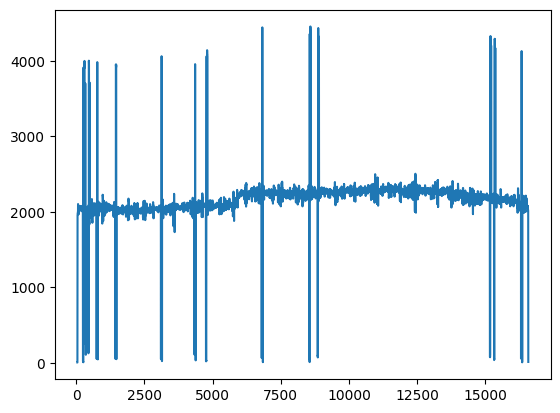

In [120]:
x = sorted(list(coverage.keys()))
y = [coverage[i] for i in x]
sns.lineplot(x = x, y = y)

In [48]:
def find_all_reads(graph, ref = "chrM"):
    read_set = []
    edgelist = sorted(graph.edges.keys())
    for edge in edgelist:
        readlist = graph.edges[edge]['reads']
        read_set += readlist
    read_set = list(set(read_set) - {ref})
    return read_set

In [49]:
import pandas as pd
import numpy
read_set = sorted(find_all_reads(graph,ref="chrM"))
read_set_dict = dict(zip(read_set, range(len(read_set))))
# filter var_record
threshold = 0.05
var_record = []
for v in Var:
    name = "m.%s%s>%s" % (v.pos, v.ref_allele, v.alt_allele)
    allele_length = numpy.abs(len(v.ref_allele) - len(v.alt_allele))
    hf = v.allele_count / coverage[v.pos]
    if allele_length == 1:
        if hf > 10 * threshold:
            var_record.append(name)
    elif hf > threshold:
        var_record.append(name)
var_record = sorted(list(set(var_record)))
var_record_dict = dict(zip(var_record, range(len(var_record))))

matrix = numpy.zeros([len(var_record), len(read_set)])

for var in var_record:

    readlist = set(Record.get(var))
    r_index = var_record_dict[var]
    for read in readlist:
        c_index = read_set_dict[read]
        matrix[r_index, c_index] += 1

In [50]:
# numpy.where(matrix>1)

In [51]:
df = pd.DataFrame(matrix, index=var_record, columns=read_set)
# freq = df.sum(axis = 1)/df.shape[1]
# print(freq.shape)
# freq = freq[freq < 0.95]
# print(freq.shape)
# freq = freq[freq > 0.1]
# print(freq.shape)
# df = df.loc[freq.index]
df1 = pd.read_csv("./mt_test.matrix.csv", header = 0, index_col = 0)

In [52]:
df.index, df1.index

(Index(['m.1437A>G', 'm.15174C>T', 'm.15325A>G', 'm.16303T>C', 'm.262A>G',
        'm.308C>CCCCT', 'm.308C>CCCT', 'm.309C>CCCT', 'm.309C>CCT', 'm.309T>C',
        'm.4335T>C', 'm.455C>T', 'm.4768A>G', 'm.6799A>G', 'm.749A>G',
        'm.8556G>A', 'm.8859A>G'],
       dtype='object'),
 Index(['m.13376T>C', 'm.1438A>G', 'm.15175C>T', 'm.15326A>G', 'm.15737G>A',
        'm.16304T>C', 'm.263A>G', 'm.308C>CCCT', 'm.309C>CCCCT', 'm.309C>CCCT',
        'm.309C>CCT', 'm.310T>C', 'm.4336T>C', 'm.456C>T', 'm.457C>T',
        'm.4769A>G', 'm.6210T>C', 'm.6800A>G', 'm.750A>G', 'm.8557G>A',
        'm.8557G>C', 'm.8558C>A', 'm.8860A>G'],
       dtype='object', name='variant'))

In [53]:
# find identical columns
# find haplotype by collapsing identical columns

# Initialize sets
def find_identical_columns(df):
    column_sets = []
    processed_cols = set()

    # Find identical columns
    for col1 in df.columns:
        if col1 in processed_cols:
            continue
        
        # Find current column set
        current_set = {col1}
        pattern = tuple(df[col1].values)  # Convert to tuple for hashing
        
        # Find identical columns
        for col2 in df.columns:
            if col2 != col1 and col2 not in processed_cols:
                if df[col1].equals(df[col2]):
                    current_set.add(col2)
                    processed_cols.add(col2)
        
        if current_set:
            column_sets.append(current_set)
            processed_cols.add(col1)

    # Create pattern dictionary
    representative_patterns = {
        next(iter(column_set)): tuple(df[next(iter(column_set))].values)
        for column_set in column_sets
    }
    return column_sets, representative_patterns
column_sets, represent   = find_identical_columns(df)
len(column_sets), df.shape


(543, (17, 2610))

In [54]:

def hierarchical_clustering_analysis(df, max_clusters=15, plot=True, labels = None):
        """
        Analyze hierarchical clustering dendrogram
        
        Args:
            plot: Whether to plot the dendrogram
            
        Returns:
            suggested_k: Suggested number of clusters based on dendrogram
        """
        # Compute linkage matrix
        Z = linkage(df, method='average', metric='jaccard')
        
        if plot:
            plt.figure(figsize=(12, 8))
            dendro = dendrogram(
                Z,
                truncate_mode='lastp',  # Show only the last p merged clusters
                p=max_clusters,
                leaf_rotation=90.,
                leaf_font_size=12.,
                show_contracted=True,
                labels=labels
            )
            # map vars to branches
            # Add markers and labels to the merging points
            icoord = np.array(dendro['icoord'])
            dcoord = np.array(dendro['dcoord'])
            for i, d in zip(icoord, dcoord):
                x = 0.5 * sum(i[1:3])
                y = d[1]
                plt.plot(x, y, 'ro')  # 'ro' means red color, circle marker
                

            # plt.xticks(range(1, len(df) + 1), df.columns)
            plt.title('Hierarchical Clustering Dendrogram', fontsize=16)
            plt.xlabel('Sample index or (cluster size)', fontsize=14)
            plt.ylabel('Distance', fontsize=14)
            plt.axhline(y=np.median(Z[-max_clusters:, 2]), color='r', linestyle='--')
            plt.tight_layout()
            plt.show()
        
        # Find where the largest vertical distance is
        last_distances = Z[-max_clusters:, 2]
        median_distance = np.median(last_distances)
        print(median_distance)
        clusters = fcluster(Z, median_distance, criterion='distance')
        suggested_k = len(np.unique(clusters))
        print(f"Suggested number of clusters (Dendrogram Analysis): {suggested_k}")
        return suggested_k, clusters

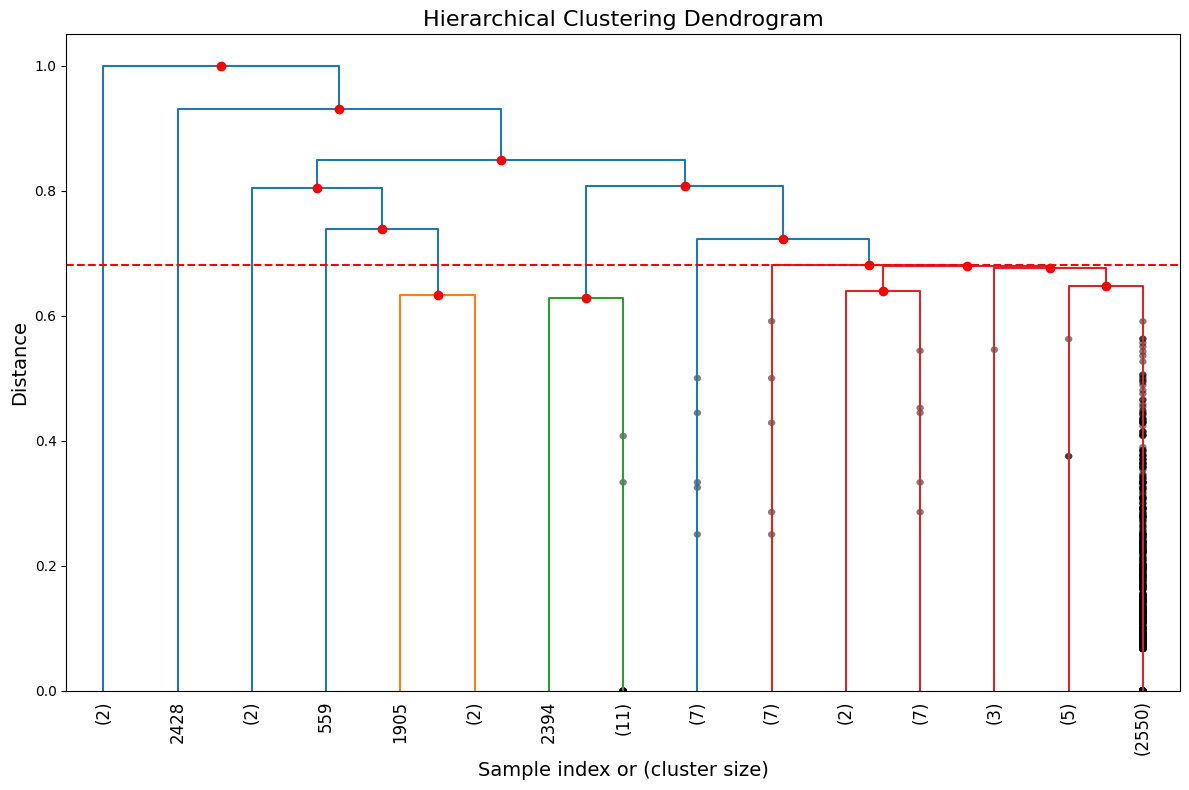

0.681603844010628
Suggested number of clusters (Dendrogram Analysis): 8


array([7, 7, 7, ..., 7, 7, 7], dtype=int32)

In [56]:
suggested_k, clusters = hierarchical_clustering_analysis(df1.T)
clusters

In [57]:
# label variants based on the cluster
Phase_set = {}
threshold = 0.6
for i in range(1, suggested_k+1):
    index_list = np.where(clusters == i)[0]
    columns = df.columns[index_list]
    subset_df = df[columns]
    variant_fraction = subset_df.sum(axis = 1)/float(subset_df.shape[1])
    variant_list = variant_fraction[variant_fraction > threshold].index
    for var in variant_list:
        Phase_set[var] = Phase_set.get(var, []) + [i]
Phase_set

{'m.1437A>G': [1, 2, 3, 4, 5, 6, 7, 8],
 'm.15174C>T': [1, 3, 4, 5, 6, 7],
 'm.15325A>G': [1, 3, 4, 5, 6, 7, 8],
 'm.16303T>C': [1, 2, 4, 5, 6, 7, 8],
 'm.262A>G': [1, 2, 3, 4, 5, 6, 7, 8],
 'm.4335T>C': [1, 4, 7, 8],
 'm.455C>T': [1, 3, 4, 5, 6, 7],
 'm.4768A>G': [1, 6, 7, 8],
 'm.749A>G': [1, 3, 4, 5, 6, 7, 8],
 'm.8556G>A': [1, 2, 3, 4, 5, 7, 8],
 'm.8859A>G': [1, 2, 3, 4, 5, 7, 8],
 'm.6799A>G': [2, 3, 4, 5, 7, 8],
 'm.309C>CCT': [3, 4, 8],
 'm.309T>C': [3, 4, 5, 7, 8]}

In [58]:
import umap

2025-03-11 13:23:58.595519: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


[-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46
 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70
 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89]
[80 81 -1 ... 64 21 57]


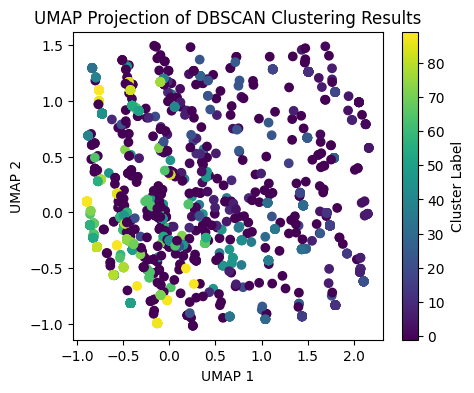

In [59]:
from sklearn.cluster import DBSCAN, HDBSCAN
from scipy.spatial.distance import pdist, squareform
from sklearn.decomposition import PCA

jaccard_distances = squareform(pdist(df.T, metric='jaccard'))
jaccard_similarity = 1 - jaccard_distances

hdbscan = HDBSCAN(min_samples=2, metric='precomputed')
clusters = hdbscan.fit_predict(jaccard_distances)
print(numpy.unique(clusters))
print(clusters)

# visualization
pca = PCA(n_components=2)
embedding = pca.fit_transform(df.T)
plt.figure(figsize=(5, 4))
plt.scatter(embedding[:, 0], embedding[:, 1], c=clusters, cmap='viridis', marker='o')
plt.title('UMAP Projection of DBSCAN Clustering Results')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.colorbar(label='Cluster Label')
plt.show()


In [60]:
def compute_within_cluster_distances(df, clusters):
    unique_clusters = np.unique(clusters)
    cluster_distances = {}
    
    for cluster in unique_clusters:
        cluster_indices = np.where(clusters == cluster)[0]
        if len(cluster_indices) > 1:
            cluster_data = df.iloc[cluster_indices, :]
            pairwise_distances = pdist(cluster_data, metric='jaccard')
            # print(pairwise_distances)
            sum_distance = np.sum(pairwise_distances)
            cluster_distances[cluster] = sum_distance
        else:
            cluster_distances[cluster] = 0.0  # No distance to compute for a single element cluster
    
    return cluster_distances

In [61]:
Z = linkage(df.T, method='complete', metric='jaccard')
max_clusters = 15
last_distances = Z[-max_clusters:, 2]
# median_distance = np.median(last_distances)


cost_for_k = 500
cluster_list = range(2, max_clusters + 1)

total_distance  = pdist(df.T, metric='jaccard')
all_total_distance = sum(total_distance)
# print(sum(all_total_distance), len(all_total_distance), 175*175)
cost_list =  np.linspace(all_total_distance/20, all_total_distance/10, 10 )

cluster_number = []
for cost_for_k in cost_list:
    Cost = []
    for number_of_cluster in cluster_list:
        clusters = fcluster(Z, number_of_cluster, criterion='maxclust')
        cluster_distances = compute_within_cluster_distances(df.T, clusters)
        total_distance = sum(cluster_distances.values())
        total_cost = total_distance + number_of_cluster * cost_for_k
        Cost.append(total_cost)
    index_minimal = numpy.where(Cost == min(Cost))[0]
    minimal_number_of_cluster = cluster_list[index_minimal[0]]
    cluster_number.append(minimal_number_of_cluster)
    

# suggested_k = len(np.unique(clusters))

In [62]:
clusters, counts = np.unique(cluster_number, return_counts=True)
index = np.argmax(counts)
suggested_k = clusters[index]
print(suggested_k)
clusters = fcluster(Z, suggested_k, criterion='maxclust')

10


In [63]:
# Phase_sets = dict(zip(df.columns, clusters))
# for var in var_record:
#     readlist = set(Record.get(var))
#     phasesets = set([Phase_sets.get(read) for read in readlist])
#     if len(phasesets) > 1:
#         print(var, phasesets)


In [64]:
# cluster = 2
# Z = linkage(df.T, method='complete', metric='jaccard')
# clusters = fcluster(Z, 2, criterion='maxclust')
# for i in range(1, cluster+1):
#     indexlist = numpy.where(clusters == i)[0]
#     c1 = df.iloc[:, indexlist]

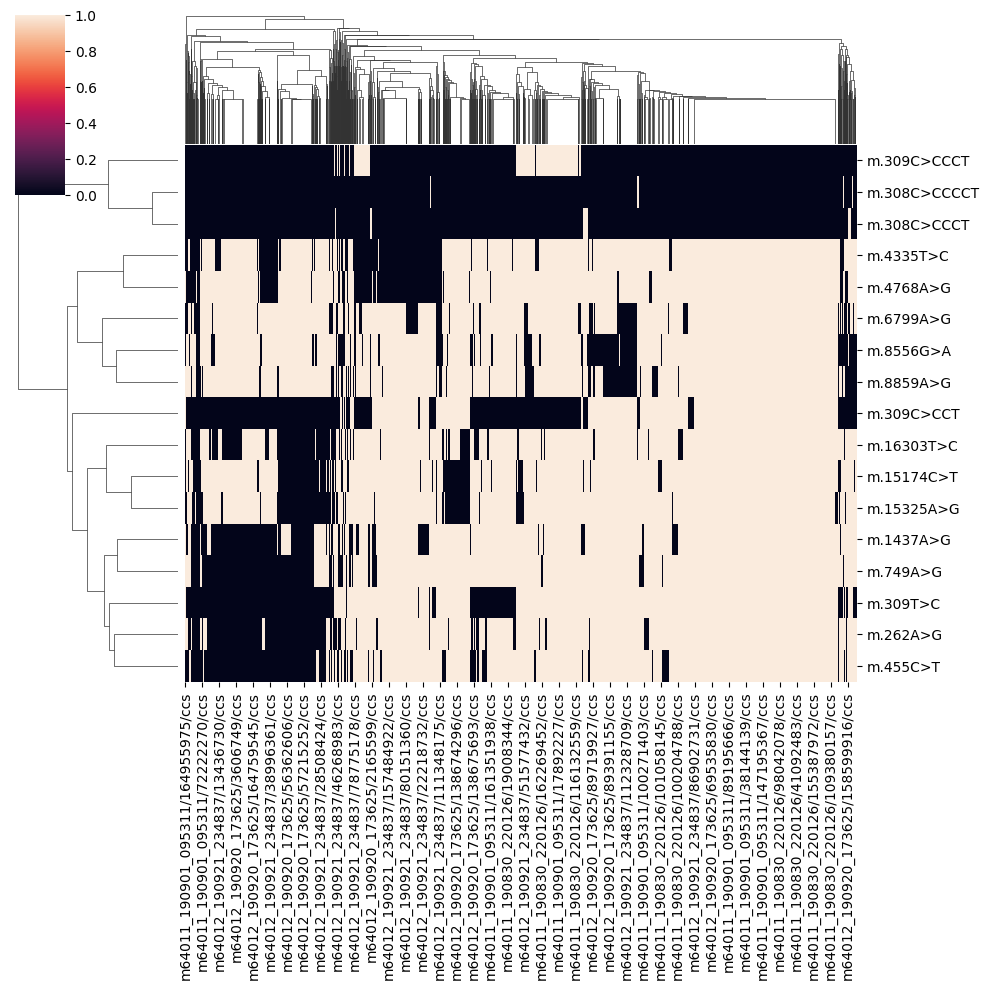

In [65]:
sns.clustermap(df)

<Axes: xlabel='variant', ylabel='variant'>

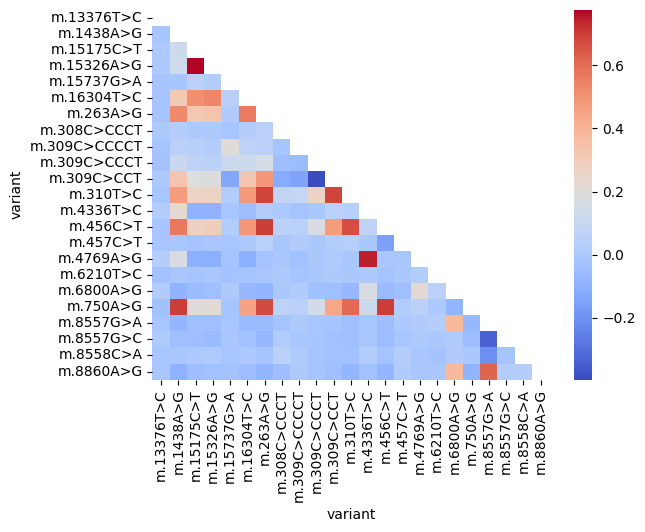

In [66]:



coor = df1.T.corr()
mask = np.triu(np.ones_like(coor, dtype=bool))
sns.heatmap(coor, mask = mask, cmap='coolwarm')

In [70]:
# df = pd.DataFrame(matrix, index=var_record, columns=read_set)
freq = df1.sum(axis = 1)/df1.shape[1]
print(freq.shape)
freq = freq[freq < 0.9]
print(freq.shape)
freq = freq[freq > 0.1]
print(freq.shape)
df_sub = df1.loc[freq.index]

(23,)
(23,)
(15,)


<Axes: xlabel='variant', ylabel='variant'>

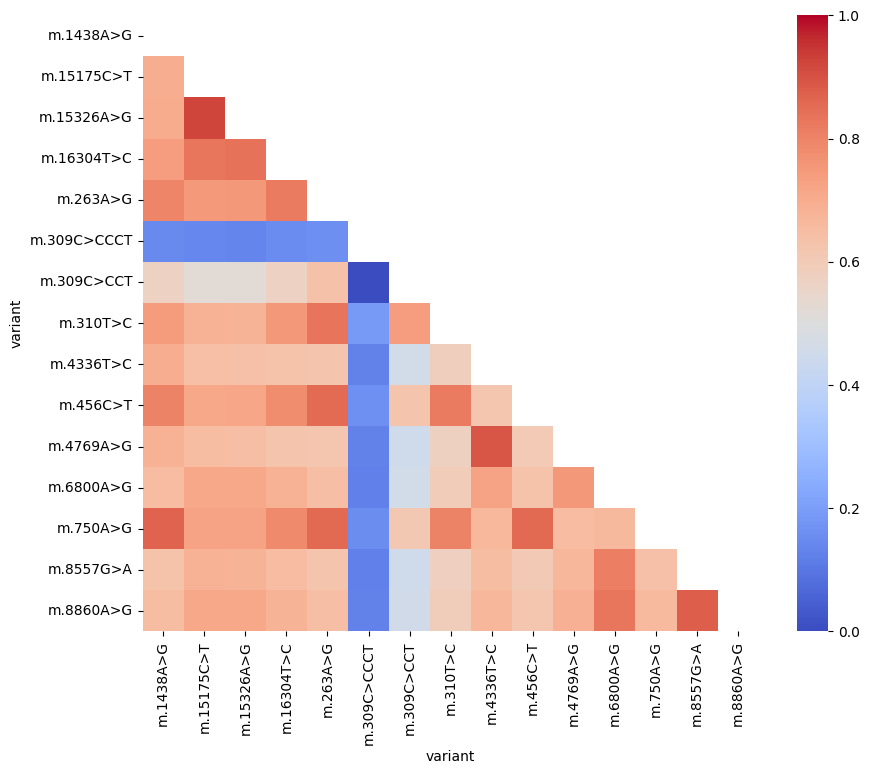

In [71]:
from scipy.spatial.distance import pdist, squareform
# Compute the Jaccard similarity matrix
jaccard_distances = pdist(df_sub, metric='jaccard')
jaccard_similarity = 1 - squareform(jaccard_distances)

# Convert the similarity matrix to a DataFrame for easier plotting
jaccard_similarity_df = pd.DataFrame(jaccard_similarity, index=df_sub.index, columns=df_sub.index)

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(jaccard_similarity_df, dtype=bool))

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Draw the heatmap with the mask
sns.heatmap(jaccard_similarity_df, mask=mask, annot=False, cmap='coolwarm', vmin=0, vmax=1, square=True)


In [435]:
# cost_list
# len(clusters), df.shape

In [436]:
# numpy.unique(cluster_number, return_counts = True)

In [437]:
# plt.plot(range(2, max_clusters + 1), Cost)
jaccard_distances.shape

(66,)

In [438]:
from Bio import Phylo
from Bio.Phylo.TreeConstruction import DistanceCalculator, DistanceTreeConstructor
from Bio.Phylo.TreeConstruction import _DistanceMatrix
from Bio import AlignIO
from Bio.Align import MultipleSeqAlignment
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq

 # Phylogenetic tree
def build_tree(df, method = "nj", distance_metric = "jaccard"):
    # Calculate distance matrix
    labels = df.columns.tolist()
    print(len(labels))
    distance = squareform(pdist(df.T, metric=distance_metric)) # row wise
    # Convert the NumPy array to a list of lists in lower triangular format
    distance_matrix = []
    for i in range(len(distance)):
        row = []
        for j in range(i + 1):
            row.append(distance[i, j])
        distance_matrix.append(row)
    distance_list = _DistanceMatrix(labels, distance_matrix) 
    
    # Create tree constructor
    constructor = DistanceTreeConstructor()
    
    # Build tree with selected method
    if method == 'nj':
        tree = constructor.nj(distance_list)
    elif method == 'upgma':
        tree = constructor.upgma(distance_list)
    else:
        raise ValueError(f"Unsupported tree construction method: {method}")
    
    return tree
    

In [471]:
import numpy as np
import pandas as pd
from Bio import Phylo
from Bio.Phylo.TreeConstruction import DistanceCalculator, DistanceTreeConstructor
from Bio.Align import MultipleSeqAlignment
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq

def annotate_tree_with_mutations(tree, data_matrix):
    """
    Annotate tree branches with mutations that define each clade
    
    Returns:
    --------
    annotations : dict
        Dictionary mapping clades to defining mutations
    """
    mutations = data_matrix.index.tolist()
    # Create a dictionary to store mutations for each clade
    clade_mutations = {}
    
    # Function to recursively process clades
    def process_clade(clade, mutations, data_matrix, parent_profile=None):
        # Get all samples in this clade
        samples = []
        for leaf in clade.get_terminals():
            samples.append(leaf.name)
        
        if not samples:
            return
        
        # Calculate mutation profile for this clade (common mutations)
        clade_profile = np.ones(len(mutations), dtype=bool)
        for sample in samples:
            if sample in data_matrix.columns:
                sample_profile = data_matrix[sample].values.astype(bool)
                clade_profile = np.logical_and(clade_profile, sample_profile) # common mutations (all ones)
        
        # Find mutations unique to this clade (not in parent)
        if parent_profile is not None:
            unique_mutations = np.logical_and(clade_profile, np.logical_not(parent_profile))
            defining_mutations = [mutations[i] for i in range(len(mutations)) if unique_mutations[i]]
            
            # Store defining mutations
            if len(defining_mutations) > 0:
                clade_mutations[clade] = defining_mutations
        else:
            # For the root clade, all mutations are defining
            defining_mutations = [mutations[i] for i in range(len(mutations)) if clade_profile[i]]
            if len(defining_mutations) > 0:
                clade_mutations[clade] = defining_mutations
        
        # Process child clades
        for child in clade.clades:
            process_clade(child, mutations, data_matrix, clade_profile)
    
    # Start from the root
    process_clade(tree.root, mutations, data_matrix)
    
    return clade_mutations


tree = build_tree(df, method="nj", distance_metric="jaccard")
clade_mutations = annotate_tree_with_mutations(tree, df) # mutations that define each clade, all 1s in this set of samples

# Convert clade_mutations to a dictionary with clade names as keys
D = {clade.name: mutations for clade, mutations in clade_mutations.items()}
# print(D.keys())



33


In [466]:
# Phylo.draw(tree)

In [467]:
 
        
# def annotate_tree_with_mutations(tree, data_matrix):
#     """
#     Annotate tree branches with mutations that define each clade
    
#     Returns:
#     --------
#     annotations : dict
#         Dictionary mapping clades to defining mutations
#     """
#     mutations = data_matrix.index.tolist()
#     # Create a dictionary to store mutations for each clade
#     clade_mutations = {}
    
#     # Function to recursively process clades
#     def process_clade(clade, mutations, data_matrix, parent_profile=np.ones(len(mutations))):
#         # Get all samples in this clade
#         samples = []
        
#         for leaf in clade.get_terminals():
#             samples.append(leaf.name)
#         if not samples:
#             return
        
#         # Calculate mutation profile for this clade (common mutations)
#         clade_profile = np.ones(len(mutations))
#         for sample in samples:
#             if sample in data_matrix.index:
#                 sample_profile = data_matrix.loc[sample].values
#                 clade_profile = np.logical_and(clade_profile, sample_profile)
        
#         # Find mutations unique to this clade (not in parent)
#         if parent_profile is not None:
#             unique_mutations = np.logical_and(clade_profile, np.logical_not(parent_profile))
#             defining_mutations = [mutations[i] for i in range(len(mutations)) 
#                                     if unique_mutations[i]]
            
#             # Store defining mutations
#             if len(defining_mutations) > 0:
#                 clade_mutations[clade] = defining_mutations
        
#         # Process child clades
#         for child in clade.clades:
#             process_clade(child, mutations, data_matrix, parent_profile=clade_profile)
#             # process_clade(clade, mutations, data_matrix, parent_profile=None)
    
#     # Start from the root
#     process_clade(tree.root, mutations, data_matrix.T)
    
#     # Print annotations
#     print("\nBranch annotations (defining mutations):")
#     for clade, mutations in clade_mutations.items():
#         # Get clade name (first leaf for identification)
#         leaves = [leaf.name for leaf in clade.get_terminals()]
#         if leaves:
#             print(f"Branch leading to {leaves[0]}: {', '.join(str(m) for m in mutations[:5])}" + 
#                     ("..." if len(mutations) > 5 else ""))
    
#     return clade_mutations

In [468]:

# clade_mutations = annotate_tree_with_mutations(tree, df)

In [469]:
def cut_tree_by_depth(tree, max_depth):
    """
    Cut the tree by depth, removing branches that exceed the specified depth.
    
    Parameters:
    -----------
    tree : Bio.Phylo.BaseTree
        Tree to cut
    max_depth : int
        Maximum depth to keep in the tree
    """
    def prune_clade(clade, current_depth):
        if current_depth >= max_depth:
            clade.clades = []
        else:
            for child in clade.clades:
                prune_clade(child, current_depth + 1)
    
    prune_clade(tree.root, 0)

33


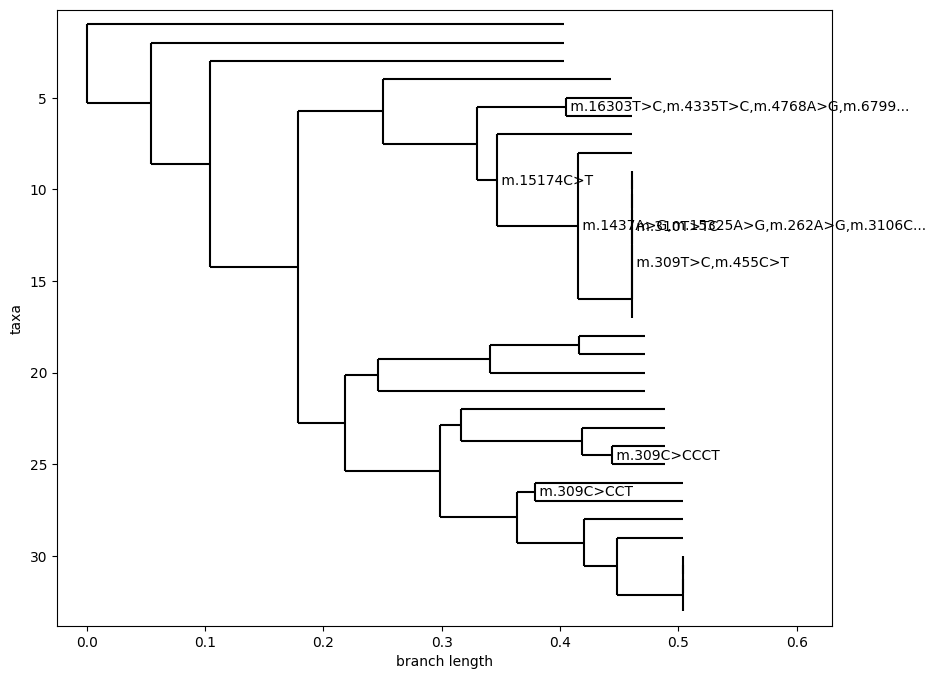

Text(0.5, 24.000000000000007, 'Branch Length')

In [470]:
import copy
import pylab
tree= build_tree(df_sub, method = "upgma", distance_metric = "jaccard")

# max_depth = 10
# cut_tree_by_depth(tree, max_depth)
clade_mutations = annotate_tree_with_mutations(tree, df_sub)


tree_copy = copy.deepcopy(tree)
for leaf in tree_copy.get_terminals():
    leaf.name = ""

mutation_pools = set()
for inner in tree_copy.get_nonterminals():
    names = D.get(inner.name, [])
    names = [str(n) for n in names if str(n) not in mutation_pools]
    mutation_pools = mutation_pools | set(names)
    inner.name = ",".join(names)
fig, ax = plt.subplots(figsize=(10, 8))
Phylo.draw(tree_copy, axes=ax, do_show=False,)
pylab.show()

ax.set_title(f'Phylogenetic Tree ', fontsize=15)
ax.set_xlabel('Branch Length', fontsize=12)

In [472]:
from Bio.Phylo.TreeConstruction import ParsimonyTreeConstructor, DistanceTreeConstructor, DistanceCalculator
from Bio.Phylo.TreeConstruction import ParsimonyScorer, NNITreeSearcher

In [446]:
 # Phylogenetic tree
def build_parsimony_tree(df):
    # Create a list to hold the sequence records
    records = []
    for sample_name in df.columns:
        seq_data = ''.join(df[sample_name].astype(str))
        record = SeqRecord(Seq(seq_data), id=str(sample_name), name=str(sample_name), description="")
        records.append(record)

    # Create alignment
    alignment = MultipleSeqAlignment(records)

    # Use a distance-based method to create an initial tree
    calculator = DistanceCalculator('identity')
    dm = calculator.get_distance(alignment)
    constructor = DistanceTreeConstructor()
    initial_tree = constructor.nj(dm)

    # Create a parsimony tree constructor
    scorer = ParsimonyScorer()
    searcher = NNITreeSearcher(scorer)
    constructor = ParsimonyTreeConstructor(searcher, initial_tree)

    # Build the parsimony tree
    parsimony_tree = constructor.build_tree(alignment)

    return parsimony_tree

In [480]:
def annotate_tree_with_mutations(tree, data_matrix):
    """
    Annotate tree branches with mutations that define each clade
    
    Returns:
    --------
    annotations : dict
        Dictionary mapping clades to defining mutations
    """
    mutations = data_matrix.index.tolist()
    # Create a dictionary to store mutations for each clade
    clade_mutations = {}
    
    # Function to recursively process clades
    def process_clade(clade, data_matrix, parent_profile=None):
        # Get all samples in this clade
        samples = []
        for leaf in clade.get_terminals():
            samples.append(leaf.name)
        
        if not samples:
            return
        
        # Calculate mutation profile for this clade (common mutations)
        # clade_profile = np.ones(len(mutations), dtype=bool)
        clade_profile = data_matrix[samples].sum(axis=1) / len(samples)
        clade_profile = clade_profile[clade_profile > 0.9].index.tolist()

        # Find mutations unique to this clade (not in parent)
        if parent_profile is not None:
            unique_mutations = [m for m in clade_profile if m not in parent_profile]
        
            # Store defining mutations
            if len(unique_mutations) > 0:
                clade_mutations[clade] = unique_mutations
        else:
            # For the root clade, all mutations are defining

            clade_mutations[clade] = clade_profile
        
        # Process child clades
        for child in clade.clades:
            process_clade(child, data_matrix, clade_profile)
    
    # Start from the root
    process_clade(tree.root, data_matrix)
    
    return clade_mutations


tree = build_tree(df, method="nj", distance_metric="jaccard")
clade_mutations = annotate_tree_with_mutations(tree, df) # mutations that define each clade, all 1s in this set of samples

# Convert clade_mutations to a dictionary with clade names as keys
D = {clade.name: mutations for clade, mutations in clade_mutations.items()}
# print(D.keys())
D



33


{'Inner31': ['m.15174C>T', 'm.15325A>G', 'm.3106CN>C', 'm.4768A>G'],
 'm64076_201016_191536/6358056/ccs': ['m.14154TC>T',
  'm.1437A>G',
  'm.16303T>C',
  'm.262A>G',
  'm.309C>CCT',
  'm.309T>C',
  'm.3106CN>C',
  'm.4335T>C',
  'm.455C>T',
  'm.4768A>G',
  'm.6799A>G',
  'm.749A>G',
  'm.8556G>A',
  'm.8859A>G'],
 'm64076_201013_225902/147849878/ccs': ['m.1437A>G',
  'm.16303T>C',
  'm.262A>G',
  'm.309C>CCT',
  'm.309T>C',
  'm.3106CN>C',
  'm.4335T>C',
  'm.455C>T',
  'm.4768A>G',
  'm.6799A>G',
  'm.8556G>A',
  'm.8859A>G',
  'm.9570A>AC'],
 'Inner22': ['m.4768A>G'],
 'Inner20': ['m.1437A>G',
  'm.262A>G',
  'm.309C>CCT',
  'm.309T>C',
  'm.455C>T',
  'm.749A>G',
  'm.8859A>G'],
 'm64076_201013_225902/163973543/ccs': ['m.16303T>C',
  'm.3106CN>C',
  'm.4768A>G',
  'm.8556G>A'],
 'Inner9': ['m.6799A>G'],
 'm54329U_201103_231616/71960591/ccs': ['m.16303T>C',
  'm.3106CN>C',
  'm.4768A>G'],
 'Inner8': ['m.1437A>G',
  'm.15325A>G',
  'm.16303T>C',
  'm.262A>G',
  'm.309T>C',
  'm.3106

In [481]:
from scipy import stats
def annotate_tree_with_diff_mutations(tree, data_matrix):
    """
    Annotate tree branches with mutations that define each clade
    
    Returns:
    --------
    annotations : dict
        Dictionary mapping clades to defining mutations
    """
    mutations = data_matrix.index.tolist()
    # Create a dictionary to store mutations for each clade
    clade_mutations = {}
    
    # Function to recursively process clades
    def process_clade(clade, mutations, data_matrix):
        # Get all samples in this clade
        samples = []
        for leaf in clade.get_terminals():
            samples.append(leaf.name)
        
        if not samples:
            return
        
        # Calculate mutation profile for this clade (common mutations)

        if len(clade.clades) > 1:
            child1_profile = data_matrix[[leaf.name for leaf in clade.clades[0].get_terminals()]]
            child2_profile = data_matrix[[leaf.name for leaf in clade.clades[1].get_terminals()]]
            child1_profile = child1_profile.sum(axis=1)/child1_profile.shape[1]
            child2_profile = child2_profile.sum(axis=1)/child2_profile.shape[1]
            # kai square test for each of the mutations for the two child clades
            # p_values = []
            # for mutation in mutations:
            #     # print(mutation, len(mutation))
            #     x1 = child1_profile.loc[mutation].values
            #     x2 = child2_profile.loc[mutation].values
            #     # calculate p between x1 and x2
            #     t_statistic, p = stats.ttest_ind(x1, x2)
            #     p_values.append(p)
            # p_values = np.array(p_values)
            # # print(p_values)
            # indexlist = np.where(p_values < 0.05)[0]
            # cmutations = [mutations[i] for i in indexlist]
            # clade_mutations[clade] = cmutations
        else:
            clade_mutations[clade] = []
        
        # Process child clades
        for child in clade.clades:
            mutations = [m for m in mutations if m not in cmutations]
            process_clade(child, mutations, data_matrix)
    
    # Start from the root
    process_clade(tree.root, mutations, data_matrix)
    
    return clade_mutations


tree = build_tree(df, method="nj", distance_metric="jaccard")
clade_mutations = annotate_tree_with_mutations(tree, df) # mutations that define each clade, all 1s in this set of samples

# Convert clade_mutations to a dictionary with clade names as keys
D = {clade.name: mutations for clade, mutations in clade_mutations.items()}
# print(D.keys())



33


In [474]:
# clade_mutations

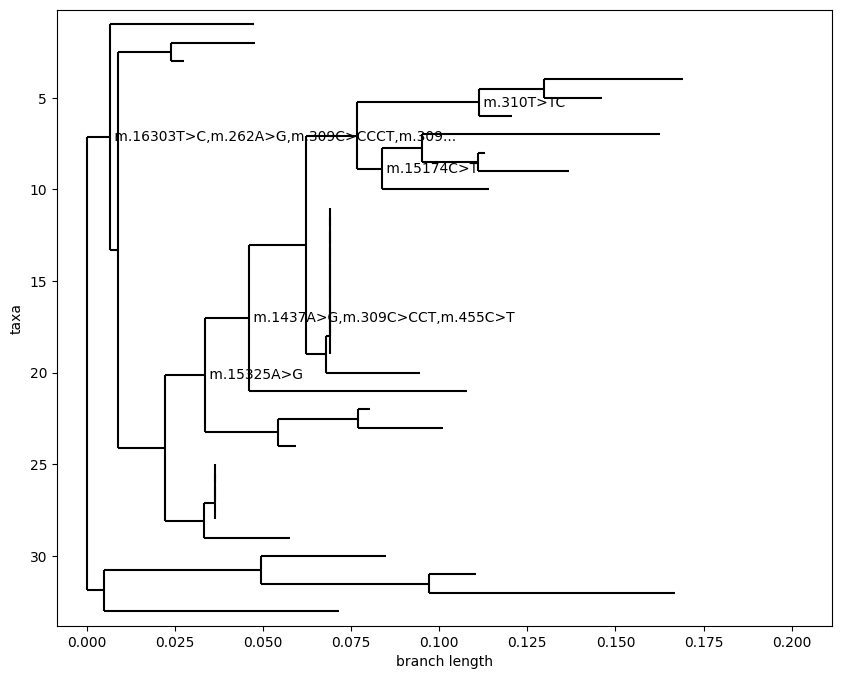

Text(0.5, 24.000000000000007, 'Branch Length')

In [482]:
parsimony_tree = build_parsimony_tree(df_sub)
clade_mutations = annotate_tree_with_mutations(parsimony_tree, df_sub)


tree_copy = copy.deepcopy(parsimony_tree)
for leaf in tree_copy.get_terminals():
    leaf.name = ""

mutation_pools = set()
for inner in tree_copy.get_nonterminals():
    names = D.get(inner.name, [])
    names = [str(n) for n in names if str(n) not in mutation_pools]
    mutation_pools = mutation_pools | set(names)
    inner.name = ",".join(names)
fig, ax = plt.subplots(figsize=(10, 8))
Phylo.draw(tree_copy, axes=ax, do_show=False, )
pylab.show()

ax.set_title(f'Phylogenetic Tree ', fontsize=15)
ax.set_xlabel('Branch Length', fontsize=12)

In [484]:
df_sub.shape

(12, 33)

In [533]:
# Using SiFit to plot the tree
# java -jar SiFit.jar -m 33 -n 12 -fp 0.002 -fn 0.2 -iter 10 -df 1 -ipMat matrix.csv
# java -cp SiFit.jar SiFit.algorithm.InferAncestralStates -fp 0.01 -fn 0.2 -w 0.01 -d 0.05 -df 0 -ipMat matrix.csv -tree matrix.csv_mlTree.newick -geneNames matrix.geneNames -cellNames matrix.samplenames  -expectedMatrix ./sifit.expected.matrix > sifit.result
df_sub = df.loc[freq.index]
indexlist = df_sub.index.tolist()
columnlist = ["sc%s" % str(i+1) for i in range(df_sub.shape[1])]
df_sub.columns = columnlist
# df_sub.index = range(len(df_sub.index))
df_sub.astype(int).to_csv("./phylogenetictree/matrix.csv", sep = " ", header = True)
with open("./phylogenetictree/matrix.genenames", "w") as f:
    for i in indexlist:
        f.write(i + "\n")
with open("./phylogenetictree/matrix.samplenames", "w") as f:
    f.write(" ".join(columnlist) + "\n")

df_depth = pd.DataFrame(np.ones(df_sub.shape), index = df_sub.index, columns = df_sub.columns)

df_depth.astype(int).to_csv("./phylogenetictree/matrix_depth.csv", sep = " ", header = True)


None
None
sc10
None
sc12
None
sc17
None
None
None
sc27
sc15
sc20
None
None
None
sc8
None
None
sc5
sc23
None
None
None
None
None
sc1
None
sc24
sc9
None
sc26
None
None
sc30
None
None
sc2
sc28
sc4
sc6
None
None
sc29
None
sc7
sc11
None
sc16
sc33
None
None
sc19
sc14
sc21
sc13
None
None
sc31
None
sc32
sc18
sc3
sc25
sc22


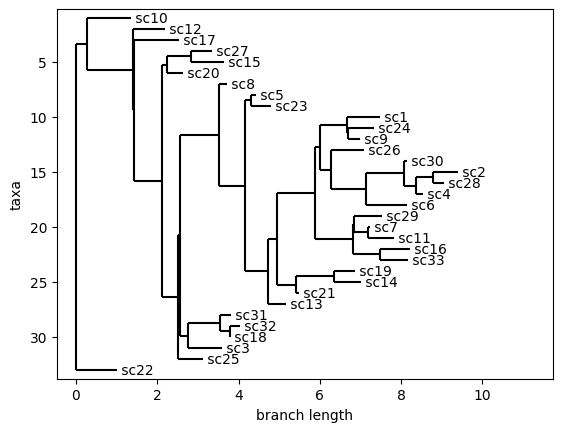

In [507]:
filename = './phylogenetictree/matrix.csv_mlTree.newick'
tree = Phylo.read(filename, "newick")
# with open("./phylogenetictree/sifit.result", 'r') as f:
#     for line in f:
#         print(line)
all_nodes = list(tree.find_clades())
for node in all_nodes:
    print(node.name)
Phylo.draw(tree)

In [397]:
# Draw the tree
# fig, ax = plt.subplots(figsize=(10, 8))
# Phylo.draw(parsimony_tree, axes=ax, do_show=False)